# Applied Machine Learning and Data Science Internship 2020, IIT Kanpur.
## Capstone Project
## Tweets Sentiment Analysis

### Introduction

We will first start by importing some dependencies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from bs4 import BeautifulSoup
from collections import Counter

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline


import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, SimpleRNN, SpatialDropout1D, Dropout, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


### Loading Data

##### Loading Training Data

In [2]:
train_df = pd.read_csv('train.txt')
pd.set_option('display.max_colwidth', None)

#reorder data
train_df = train_df[['tweet_id', 'tweet_text', 'sentiment']]

train_df.head()

,tweet_id,tweet_text,sentiment
0,264183816548130816,Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :),positive
1,263405084770172928,Theo Walcott is still shit\u002c watch Rafa and Johnny deal with him on Saturday.,negative
2,262163168678248449,its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.,negative
3,264249301910310912,Iranian general says Israel\u2019s Iron Dome can\u2019t deal with their missiles (keep talking like that and we may end up finding out),negative
4,262682041215234048,Tehran\u002c Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney,neutral


In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    21465 non-null  int64 
 1   tweet_text  21465 non-null  object
 2   sentiment   21465 non-null  object
dtypes: int64(1), object(2)
memory usage: 503.2+ KB


##### Load test data.

In [84]:
test_df = pd.read_csv('test_samples.txt')
pd.set_option('display.max_colwidth', None)
test_df.head()

,tweet_id,tweet_text
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow"
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not"
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt"
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs"


Let's see how the samples are distributed across the classes.

positive    9064
neutral     9014
negative    3387
Name: sentiment, dtype: int64


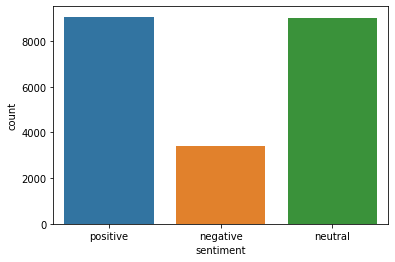

In [85]:
print(train_df.sentiment.value_counts())
sns.countplot(x = 'sentiment', data = train_df)

From above graph we can see the data is not well balanced and the negative class having the least number of samples with only 3387 enteries where as the positive and neutral class hava almost same count of samples but they both are approx 2.8 times of negative class. This can lead to prediction favouring the majority classes and ignoring the minority class. We can come back to this later.

### Cleaning The Data

Now we will preprocess or clean the data before we can perform prediction on it. We will follow the following order.

1. Remove unicode characters
2. Covert to lower case
3. HTML decoding (removing &amp, etc)
4. Remove Twitter mentions (@someone)
5. Remove URLs (like https://... , http://....., www. )
6. Remove stop words.

In [3]:
def tweet_text_cleaner(tweet):
    tweet = tweet.encode('utf-8').decode('unicode_escape')
    tweet = tweet.lower()
    tweet = BeautifulSoup(tweet, 'lxml').getText()
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub('http?://[A-Za-z0-9./]+', '', tweet)
    tweet = re.sub('https?://[A-Za-z0-9./]+','', tweet)
    tweet = re.sub('www?.[A-Za-z0-9./]+', '', tweet)
    tokens = word_tokenize(tweet)
    tweet = [word for word in tokens if not word in stop_words and word.isalpha()]
    return (" ".join(tweet))

We can test now if our cleaning function works as intended.

In [88]:
train_df.tweet_text[:10]

0                                                                                          Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
1                                                                               Theo Walcott is still shit\u002c watch Rafa and Johnny deal with him on Saturday.
2                                                                      its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.
3                         Iranian general says Israel\u2019s Iron Dome can\u2019t deal with their missiles (keep talking like that and we may end up finding out)
4                 Tehran\u002c Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney
5                                                                                      I sat through this whole movie just for Harry and Ron at christmas. ohlawd
6                           

In [89]:
[tweet_text_cleaner(tweet) for tweet in train_df.tweet_text[:10]]

['gas house hit going chapel hill sat',
 'theo walcott still shit watch rafa johnny deal saturday',
 'gsp fan hate nick diaz wait february',
 'iranian general says israel iron dome deal missiles keep talking like may end finding',
 'tehran mon amour obama tried establish ties mullahs via barack obama vote mitt romney',
 'sat whole movie harry ron christmas ohlawd',
 'j davlar main rivals team poland hopefully make successful end tough week training tomorrow',
 'talking act sat deciding want go college applying colleges everything college stresses',
 'happy valentines day trending february june',
 'may superbowl dallas dallas winning superbowl quarterback owner']

Looks Good for now but preprocessing is never perfect :)
Now we can save the cleaned tweets in a seperate column.

In [4]:
train_df['clean_tweet'] = train_df['tweet_text'].apply(tweet_text_cleaner)
train_df.head()

,tweet_id,tweet_text,sentiment,clean_tweet
0,264183816548130816,Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :),positive,gas house hit going chapel hill sat
1,263405084770172928,Theo Walcott is still shit\u002c watch Rafa and Johnny deal with him on Saturday.,negative,theo walcott still shit watch rafa johnny deal saturday
2,262163168678248449,its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.,negative,gsp fan hate nick diaz wait february
3,264249301910310912,Iranian general says Israel\u2019s Iron Dome can\u2019t deal with their missiles (keep talking like that and we may end up finding out),negative,iranian general says israel iron dome deal missiles keep talking like may end finding
4,262682041215234048,Tehran\u002c Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney,neutral,tehran mon amour obama tried establish ties mullahs via barack obama vote mitt romney


A feature with character length of cleaned tweets will be good will be good.

In [5]:
train_df['text_length'] = train_df['clean_tweet'].apply(len)
train_df['text_length'].describe()

count    21465.000000
mean        67.402888
std         43.282333
min          0.000000
25%         53.000000
50%         68.000000
75%         81.000000
max       3652.000000
Name: text_length, dtype: float64

This is a little bit strange we can see we have some tweets with 0 length and some with greater than 280 (previously 140) so we can safely remove the ones with length greater than 280.

In [6]:
train_df.drop(train_df.loc[train_df['text_length'] == 0].index, inplace = True)
train_df.drop(train_df.loc[train_df['text_length'] > 280].index, inplace = True)

In [7]:
train_df['text_length'].describe()

count    21458.000000
mean        66.847003
std         19.411252
min          8.000000
25%         53.000000
50%         68.000000
75%         81.000000
max        132.000000
Name: text_length, dtype: float64

##### Clean test data.

In [94]:
test_df['clean_tweet'] = test_df['tweet_text'].apply(tweet_text_cleaner)
test_df.head()

,tweet_id,tweet_text,clean_tweet
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow",atlantic city ventnor margate ocean city area waiting coordinator hopefully call tomorrow
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not",musical awareness great big beautiful tomorrow ending time
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6,fri oct labour analyst shawn hattingh cosatu role context unrest mining
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt",kapan sih lo ngebuktiin jan ngomong doang susah aja blm udh nyerah never try never kok gentle bgt
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs",excuse connectivity live stream baba amr many activists using one sat modem live homs


### Data Visualization

We will start with WordCloud, looking most frequent words in each class.

#### WordCloud Neutral Cass

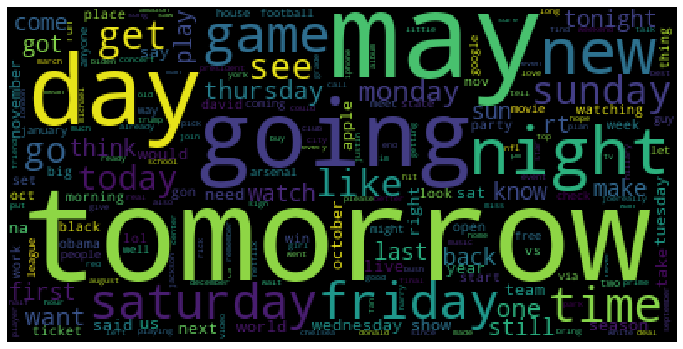

In [95]:
neutral_df = train_df.loc[train_df['sentiment'] == 'neutral']
neutral_df_text = neutral_df['clean_tweet'].to_string()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(neutral_df_text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### WordCloud Positive Class

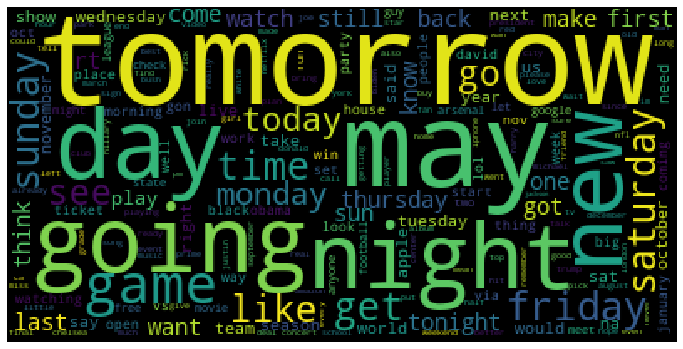

In [96]:
positive_df = train_df.loc[train_df['sentiment'] == 'positive']
positive_df_text = neutral_df['clean_tweet'].to_string()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(positive_df_text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### WordCloud Negative Class

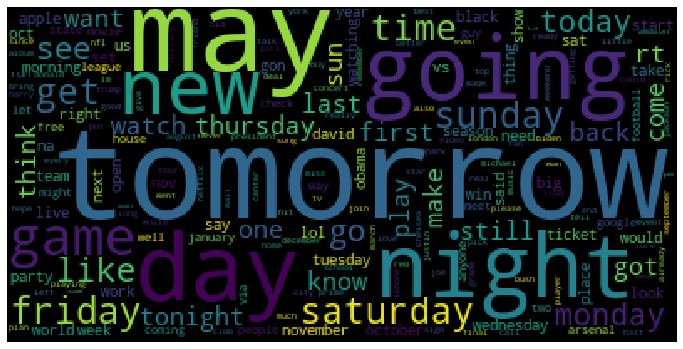

In [97]:
negative_df = train_df.loc[train_df['sentiment'] == 'negative']
negative_df_text = neutral_df['clean_tweet'].to_string()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(negative_df_text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can see words like 'tomorrow', 'may', 'day', 'game', 'friday', etc. are most common words in all three classes. Let us dive more into this.

We will now look at the words on the basis of term frequency in each class i.e how many times each word appears in each class. We will use CountVectorizer here to get the features and calculate term frequencies.

In [98]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train_df.clean_tweet)
print('Total features = ', len(count_vectorizer.get_feature_names()))

Total features =  25972


We have got total 25972 words in our training data.

In [99]:
neutral_sentiment_mat = count_vectorizer.transform(train_df[train_df.sentiment == 'neutral'].clean_tweet)
positive_sentiment_mat = count_vectorizer.transform(train_df[train_df.sentiment == 'positive'].clean_tweet)
negative_sentiment_mat = count_vectorizer.transform(train_df[train_df.sentiment == 'negative'].clean_tweet)

neutral_term_freq = np.sum(neutral_sentiment_mat, axis=0)
postive_term_freq = np.sum(positive_sentiment_mat, axis=0)
negative_term_freq = np.sum(negative_sentiment_mat, axis=0)

neutral = np.squeeze(np.asarray(neutral_term_freq))
positive = np.squeeze(np.asarray(postive_term_freq))
negative = np.squeeze(np.asarray(negative_term_freq))

term_freq_df = pd.DataFrame([neutral, positive, negative], columns = count_vectorizer.get_feature_names()).transpose()
term_freq_df.columns = ['neutral', 'positive', 'negative']
term_freq_df['total'] = term_freq_df['neutral'] + term_freq_df['negative'] + term_freq_df['positive']

In [100]:
# Now we can check most frequent 10 words in all classes 
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,neutral,positive,negative,total
tomorrow,1348,1733,464,3545
may,1108,1079,641,2828
day,609,897,232,1738
going,634,660,225,1519
night,579,707,174,1460
friday,531,584,130,1245
see,385,718,142,1245
like,409,473,276,1158
time,449,523,175,1147
game,524,456,154,1134


In [101]:
# Now we can check most frequent 10 words in neutral classe 
term_freq_df.sort_values(by='neutral', ascending=False).iloc[:10]

,neutral,positive,negative,total
tomorrow,1348,1733,464,3545
may,1108,1079,641,2828
going,634,660,225,1519
day,609,897,232,1738
night,579,707,174,1460
friday,531,584,130,1245
game,524,456,154,1134
saturday,501,471,115,1087
sunday,479,500,138,1117
time,449,523,175,1147


In [102]:
# Now we can check most frequent 10 words in poitive class
term_freq_df.sort_values(by='positive', ascending=False).iloc[:10]

,neutral,positive,negative,total
tomorrow,1348,1733,464,3545
may,1108,1079,641,2828
day,609,897,232,1738
see,385,718,142,1245
night,579,707,174,1460
going,634,660,225,1519
good,84,589,72,745
friday,531,584,130,1245
time,449,523,175,1147
sunday,479,500,138,1117


In [103]:
# Now we can check most frequent 10 words in negative class 
term_freq_df.sort_values(by='negative', ascending=False).iloc[:10]

,neutral,positive,negative,total
may,1108,1079,641,2828
tomorrow,1348,1733,464,3545
like,409,473,276,1158
day,609,897,232,1738
going,634,660,225,1519
get,435,459,193,1087
time,449,523,175,1147
night,579,707,174,1460
go,377,429,165,971
game,524,456,154,1134


### Setting up a baseline

Before actually begining to create a model we should create a baseline so that we can know how better our models perform. We can use the python library Textblob for this task. In addition to providing great features like  part-of-speech tagging, noun phrase extraction, classification, etc it also provides a basic sentiment analysis feature which we can use for our baseline. Then senitment() function of the TextBlob library returns a polarity in range[-1, 1] where -1 being most neagtive and 1 being most positive. We will check using TextBlob to predict three classes 'neutral', 'postiive' and 'negative' classes on the test data and submitting on Kaggle to get mean F-score.

##### Get sentiment using TextBlob
Here we will consider if the polarity is 0 it will be considered as 'neutral'. Below 0 considered as 'negative' and above 0 as 'positive' 

In [104]:
def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [32]:
test_df['sentiment'] = test_df['clean_tweet'].apply(lambda x: get_tweet_sentiment(x))
test_df.head()

,tweet_id,tweet_text,clean_tweet,sentiment
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow",atlantic city ventnor margate ocean city area im waiting coordinator hopefully call tomorrow,neutral
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not",musical awareness great big beautiful tomorrow ending time,positive
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6,fri oct labour analyst shawn hattingh cosatus role context unrest mining,neutral
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt",kapan sih lo ngebuktiinjan ngomong doang susah susahusaha aja blm udh nyerahingetif never try youll never knowcowok kok gentle bgt,positive
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs",excuse connectivity live stream baba amr many activists using one sat modem live homs,positive


We will now prepare the submission file by exporting the above dataframe to a csv.

In [33]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .55210 using TextBlob
This will be our baseline moving forward.

#### Traditional Machine Learning Classifiers

Before moving on to building a complex neural network model using RNNs, LSTMs, CNNs, etc. we will first check how the algorithms like Logistic Regression, RandomForest, DecisionTree, etc. perform. We will use sklearn for their implementation.

We will split the training data into 80-20 that is we will use 80% as training data and 20% as validation data. 

In [107]:
X = train_df.clean_tweet
y = train_df.sentiment
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

We will use following classifiers and compare their results.

In [106]:
classifiers = {
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [108]:
f1_scores = dict()
def evaluate_classifier(classifier):
    pipe_line = Pipeline([('vect', TfidfVectorizer(stop_words=None, max_features=10000, ngram_range=(1, 3))),
                ('clf',  classifier),
               ])
    pipe_line.fit(X_train, y_train)
    y_pred = pipe_line.predict(X_val)

    print(classifier)
    f1_scores[classifier] = f1_score(y_pred, y_val, average='weighted')
    print('Accuracy %s' % accuracy_score(y_pred, y_val))
    print('F1-score %s' % f1_scores[classifier])
    print(classification_report(y_val, y_pred))

    confmat = confusion_matrix(y_val, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.title(classifier)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    return pipe_line

AdaBoostClassifier()
Accuracy 0.5664026095060578
F1-score 0.5966450875083971
              precision    recall  f1-score   support

    negative       0.49      0.19      0.27       642
     neutral       0.51      0.88      0.64      1813
    positive       0.78      0.39      0.52      1837

    accuracy                           0.57      4292
   macro avg       0.59      0.49      0.48      4292
weighted avg       0.62      0.57      0.54      4292

DecisionTreeClassifier()
Accuracy 0.5563839701770736
F1-score 0.5595117881186039
              precision    recall  f1-score   support

    negative       0.31      0.28      0.30       642
     neutral       0.58      0.56      0.57      1813
    positive       0.61      0.65      0.63      1837

    accuracy                           0.56      4292
   macro avg       0.50      0.50      0.50      4292
weighted avg       0.55      0.56      0.55      4292

RandomForestClassifier()
Accuracy 0.6397949673811743
F1-score 0.6577412663615481

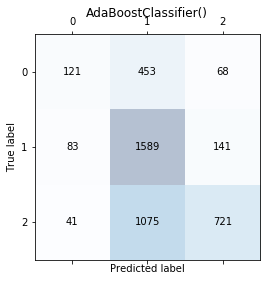

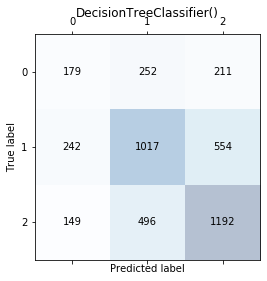

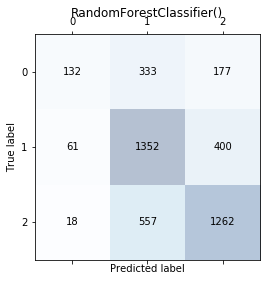

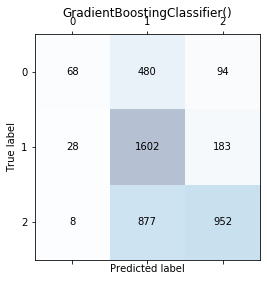

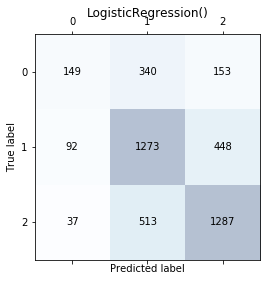

In [109]:
for classifier in classifiers:
    evaluate_classifier(classifiers[classifier])

In [110]:
f1_scores

{AdaBoostClassifier(): 0.5966450875083971,
 DecisionTreeClassifier(): 0.5595117881186039,
 RandomForestClassifier(): 0.6577412663615481,
 GradientBoostingClassifier(): 0.6451295683526997,
 LogisticRegression(): 0.6451126185619539}

We will try to use logistic regression on our test data and submit to kaggle. Also we have class imbalanace in our training data so we will use the in-built property of LogisticRegression() `class_weight` and set it to `balanced` and see how our model performs.

LogisticRegression(class_weight='balanced')
Accuracy 0.6123019571295434
F1-score 0.6063476775862511
              precision    recall  f1-score   support

    negative       0.39      0.53      0.45       642
     neutral       0.63      0.59      0.61      1813
    positive       0.71      0.66      0.68      1837

    accuracy                           0.61      4292
   macro avg       0.58      0.60      0.58      4292
weighted avg       0.63      0.61      0.62      4292



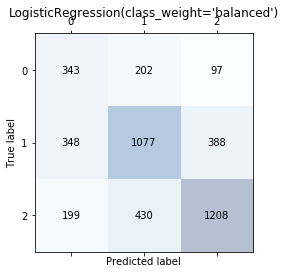

In [111]:
lg_pipe_line = evaluate_classifier(LogisticRegression(class_weight = 'balanced'))

In [112]:
test_df['sentiment'] = lg_pipe_line.predict(test_df['clean_tweet'])
test_df.head()

,tweet_id,tweet_text,clean_tweet,sentiment
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow",atlantic city ventnor margate ocean city area waiting coordinator hopefully call tomorrow,neutral
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not",musical awareness great big beautiful tomorrow ending time,positive
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6,fri oct labour analyst shawn hattingh cosatu role context unrest mining,neutral
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt",kapan sih lo ngebuktiin jan ngomong doang susah aja blm udh nyerah never try never kok gentle bgt,negative
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs",excuse connectivity live stream baba amr many activists using one sat modem live homs,neutral


In [46]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .65076 using LogisticRegression which is an improvement from TextBlob having a mean F-score of .55210

### Handling Imbalanced data

positive    9059
neutral     9012
negative    3387
Name: sentiment, dtype: int64


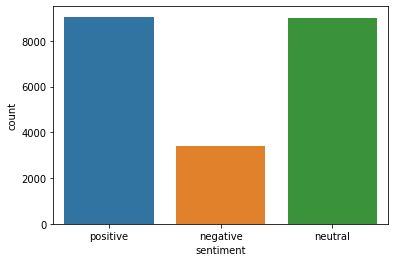

In [113]:
print(train_df.sentiment.value_counts())
sns.countplot(x = 'sentiment', data = train_df)

From the above graph we can say that we have class imbalance in our training data i.e the 'neagtive' class is nearly 1/3 of the other two classes 'positive' and 'negative'. This can lead to the model ignoring the minority class and favouring the majority class with greater number of samples. <br>
Here we will try OverSampling our data using the following two techniques. <br>
    1. RandomOverSampler <br>
    2. SMOTE (Synthetic Minority Over-Sampling Technique) 
<br>
We will use a python library called `imblearn` to get these done.

In [9]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

Random over-sampling is simply a process of repeating some samples of the minority class and balance the number of samples between classes in the dataset.

In [21]:
X = train_df.clean_tweet
y = train_df.sentiment
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 1000)
tf_idf_vec = TfidfVectorizer(stop_words=None, max_features=40000, ngram_range=(1, 3))
log_reg_cls = LogisticRegression()
rand_over_sample_pipeline = make_pipeline(tf_idf_vec, RandomOverSampler(random_state=1000), log_reg_cls)

Accuracy 0.619990680335508
F1-score 0.618184541125921
              precision    recall  f1-score   support

    negative       0.46      0.52      0.49       699
     neutral       0.62      0.61      0.62      1798
    positive       0.69      0.67      0.68      1795

    accuracy                           0.62      4292
   macro avg       0.59      0.60      0.59      4292
weighted avg       0.62      0.62      0.62      4292



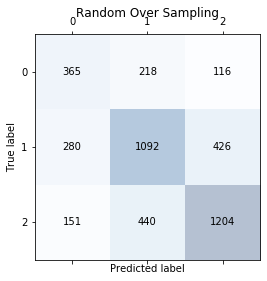

In [22]:
rand_over_sample_pipeline.fit(X_train, y_train)
y_pred = rand_over_sample_pipeline.predict(X_val)

f1_s = f1_score(y_pred, y_val, average='weighted')
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print('F1-score %s' % f1_s)
print(classification_report(y_val, y_pred))

confmat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.title("Random Over Sampling")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

We got a F1-score of 0.6235 which is slightly better than our LogisticRegression Model, lets see how it perform on test data.

In [30]:
test_df['sentiment'] = rand_over_sample_pipeline.predict(test_df['clean_tweet'])
test_df.head()

,tweet_id,tweet_text,clean_tweet,sentiment
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow",down in the atlantic city ventnor margate ocean city area im just waiting for the coordinator to hopefully call me tomorrow,positive
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not",musical awareness great big beautiful tomorrow has an ending now is the time does not,positive
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6,on fri oct labour analyst shawn hattingh cosatus role in the context of unrest in the mining,neutral
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt",kapan sih lo ngebuktiinjan ngomong doang susah susahusaha aja blm udh nyerahingetif you never try youll never knowcowok kok gentle bgt,negative
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs",excuse the connectivity of this live stream from baba amr so many activists using only one sat modem live homs,neutral


In [104]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .65145 which is slightly better than .65076 of LogisticRegression.

Lets move on to SMOTE

In [12]:
smote_pipeline = make_pipeline(tf_idf_vec, SMOTE(random_state=1000), log_reg_cls)

Accuracy 0.6178937558247903
F1-score 0.6138588459662743
              precision    recall  f1-score   support

    negative       0.40      0.51      0.45       642
     neutral       0.62      0.60      0.61      1813
    positive       0.71      0.67      0.69      1837

    accuracy                           0.62      4292
   macro avg       0.58      0.59      0.58      4292
weighted avg       0.63      0.62      0.62      4292



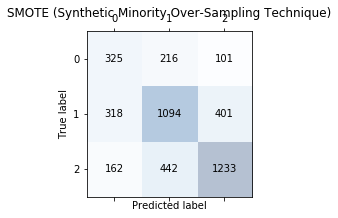

In [15]:
smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_val)

f1_s = f1_score(y_pred, y_val, average='weighted')
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print('F1-score %s' % f1_s)
print(classification_report(y_val, y_pred))

confmat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.title("SMOTE (Synthetic Minority Over-Sampling Technique)")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

We got a F1-score of 0.6242 which is slightly better than our Random Over Sampler Model, lets see how it perform on test data.

In [34]:
test_df['sentiment'] = smote_pipeline.predict(test_df['clean_tweet'])
test_df.head()

,tweet_id,tweet_text,clean_tweet,sentiment
0,264238274963451904,"@jjuueellzz down in the Atlantic city, ventnor, margate, ocean city area. I'm just waiting for the coordinator to hopefully call me tomorrow",down in the atlantic city ventnor margate ocean city area im just waiting for the coordinator to hopefully call me tomorrow,negative
1,218775148495515649,"Musical awareness: Great Big Beautiful Tomorrow has an ending, Now is the time does not",musical awareness great big beautiful tomorrow has an ending now is the time does not,positive
2,258965201766998017,On Radio786 100.4fm 7:10 Fri Oct 19 Labour analyst Shawn Hattingh: Cosatu's role in the context of unrest in the mining http://t.co/46pjzzl6,on fri oct labour analyst shawn hattingh cosatus role in the context of unrest in the mining,neutral
3,262926411352903682,"Kapan sih lo ngebuktiin,jan ngomong doang Susah Susah.usaha Aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt",kapan sih lo ngebuktiinjan ngomong doang susah susahusaha aja blm udh nyerahingetif you never try youll never knowcowok kok gentle bgt,negative
4,171874368908050432,"Excuse the connectivity of this live stream, from Baba Amr, so many activists using only one Sat Modem. LIVE http://t.co/U283IhZ5 #Homs",excuse the connectivity of this live stream from baba amr so many activists using only one sat modem live homs,neutral


In [35]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .65470 which is slightly better than Random Over Sampler.

#### Classification using Neural Networks

After exploring Logistic Regression which very similar to a single layer neural network now we will move to Neural Networks for our classification. In this section we will use first a simple neural network then move on to more complex ones and networks like LSTMs (Long Short Term Memory) and CNNs-LSTMs combinations we wil discuss about them in detail when we work on them.



We will start with a simple Neural Network with 128 hidden layers and we will continue to use TFIDFVectorizer.

In [23]:
X = train_df.clean_tweet
y = train_df.sentiment

y = pd.get_dummies(train_df['sentiment']).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)
tf_idf_vec = TfidfVectorizer(stop_words=None, max_features=40000, ngram_range=(1, 3))

tf_idf_vec.fit(X_train)

TfidfVectorizer(max_features=40000, ngram_range=(1, 3))

In [24]:
x_train_tfidf = tf_idf_vec.transform(X_train)
x_validation_tfidf = tf_idf_vec.transform(X_val)

In [25]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=40000))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

model.fit(x_train_tfidf, y_train, validation_data=(x_validation_tfidf, y_val), epochs=2, batch_size=128, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               5120128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 5,120,515
Trainable params: 5,120,515
Non-trainable params: 0
_________________________________________________________________
None
Train on 17166 samples, validate on 4292 samples
Epoch 1/2
 - 16s - loss: 0.9789 - acc: 0.5444 - val_loss: 0.8690 - val_acc: 0.6130
Epoch 2/2
 - 16s - loss: 0.6946 - acc: 0.7113 - val_loss: 0.8090 - val_acc: 0.6249


Accuracy 0.624883504193849
F1-score 0.6405856214487828
              precision    recall  f1-score   support

           0       0.53      0.21      0.31       642
           1       0.60      0.67      0.63      1813
           2       0.66      0.72      0.69      1837

   micro avg       0.62      0.62      0.62      4292
   macro avg       0.60      0.54      0.54      4292
weighted avg       0.62      0.62      0.61      4292
 samples avg       0.62      0.62      0.62      4292



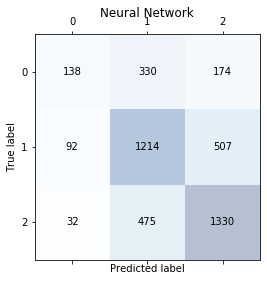

In [26]:
y_pred = model.predict_classes(x_validation_tfidf)
y_pred = pd.get_dummies(y_pred).values

f1_s = f1_score(y_pred, y_val, average='weighted')
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print('F1-score %s' % f1_s)
print(classification_report(y_val, y_pred))

confmat = confusion_matrix(y_val.argmax(axis = 1) , y_pred.argmax(axis = 1))

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.title("Neural Network")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

We got a F1-score of 0.6405 which is better than our SMOTE Model, lets see how it perform on test data.

In [150]:
y_test_pred = model.predict_classes(tf_idf_vec.transform(test_df['clean_tweet']))
y_test_pred

array([1, 2, 1, ..., 1, 2, 2], dtype=int64)

In [151]:
sent_list = []
for i in y_test_pred:
    if i == 0:
        sent_list.append("negative")
    elif i == 1:
        sent_list.append("neutral")
    else:
        sent_list.append("positive")
        
test_df['sentiment'] = sent_list 

In [156]:
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5398 non-null   int64 
 1   sentiment  5398 non-null   object
dtypes: int64(1), object(1)
memory usage: 84.5+ KB


In [157]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .64636 which is lower than the LogisticRegression with SMOTE model.

#### LSTM Networks

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width= 500>

We will create a neural network with single layer of 128 LSTM cells and see how it performs. We will add an Embedding Layer with 40000 features.

In [27]:
from keras.preprocessing.text import Tokenizer

X = train_df.clean_tweet

y = pd.get_dummies(train_df['sentiment']).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

max_features = 40000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

from keras.preprocessing import sequence
max_words = 140
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

In [28]:
model = Sequential()
model.add(Embedding(max_features, max_words, input_length=X_train.shape[1]))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=128, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 140)          5600000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               137728    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 5,738,115
Trainable params: 5,738,115
Non-trainable params: 0
_________________________________________________________________
None
Train on 17166 samples, validate on 4292 samples
Epoch 1/2
 - 72s - loss: 0.9557 - acc: 0.5137 - val_loss: 0.8355 - val_acc: 0.6125
Epoch 2/2
 - 75s - loss: 0.6715 - acc: 0.7138 - val_loss: 0.8303 - val_acc: 0.6207


Accuracy 0.6206896551724138
F1-score 0.6177379746056479
              precision    recall  f1-score   support

           0       0.46      0.37      0.41       642
           1       0.60      0.65      0.63      1813
           2       0.69      0.68      0.68      1837

    accuracy                           0.62      4292
   macro avg       0.58      0.57      0.57      4292
weighted avg       0.62      0.62      0.62      4292



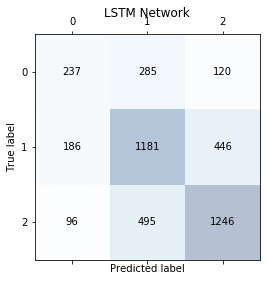

In [29]:
y_pred = model.predict_classes(X_val)

f1_s = f1_score(np.argmax(y_val, axis = 1), y_pred, average='weighted')
print('Accuracy %s' % accuracy_score(y_pred, np.argmax(y_val, axis = 1)))
print('F1-score %s' % f1_s)
print(classification_report(np.argmax(y_val, axis = 1), y_pred))

confmat = confusion_matrix(y_val.argmax(axis = 1) , y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.title("LSTM Network")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

We got a F1-score of 0.6177 which is lower than our single hidden layer Model, lets see how it perform on test data.

In [154]:
y_test_pred = model.predict_classes(sequence.pad_sequences(tokenizer.texts_to_sequences(test_df['clean_tweet']), maxlen=max_words))
y_test_pred

array([2, 2, 1, ..., 1, 2, 2], dtype=int64)

In [71]:
sent_list = []
for i in y_test_pred:
    if i == 0:
        sent_list.append("negative")
    elif i == 1:
        sent_list.append("neutral")
    else:
        sent_list.append("positive")
        
test_df['sentiment'] = sent_list 

In [72]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .64080 which is higher than the simple dense layer neural network model.

#### CNN-LSTM Model

Convolutional Neural Networks (CNN)
CNNs are mainly used in the world of Computer Vision but in many papers [Kim Y. Convolutional Neural Networks for Sentence Classification. 2014] we get to know that they show promising results in NLP also. THe very intuition behind CNN is to extract patterns in small group of data here in NLP we can think this like small phrases ("I like this"), ("Its bad"), etc. We can stack multiple CNN layers each with different kernel size (2, 3, 4, 5) referring to 2 words phrases, 3 word phrases and so on. Following figure very clearly depicts the intuition behind the use of CNN in text classification. We mostly use the Convolutional layer to extract local feature.

<img src="https://miro.medium.com/max/700/0*0efgxnFIaLTZ2qkY" width= 500>
<center>Zhang, Y., & Wallace, B. (2015) 'A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification'</center>
<br>
A combination of CNN and LSTM works good because CNN helps to extract local feature and LSTMs are good for Long term dependency of data.
For our model we are using 4 Convolutional Layer each with 128 filters and kernel size of [2,3,4,5]. We also add an max pool layer with pool size 2 after each convlutional layer and then we add a LSTM layer with 264 units with dropout of value 0.2 and also a recurrent dropout of 0.2 to lower overfitting and make the model better generalize on the data.

In [31]:
model = Sequential()
model.add(Embedding(max_features, max_words, input_length=X_train.shape[1]))
model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=128, verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 140)          5600000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 140, 128)          35968     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 70, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 70, 128)           49280     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 35, 128)           65664     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 17, 128)          

Accuracy 0.625116495806151
F1-score 0.6222661865588629
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       642
           1       0.61      0.62      0.61      1813
           2       0.69      0.71      0.70      1837

    accuracy                           0.63      4292
   macro avg       0.59      0.58      0.58      4292
weighted avg       0.62      0.63      0.62      4292



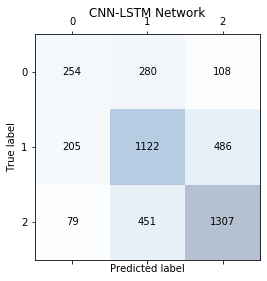

In [32]:
y_pred = model.predict_classes(X_val)

f1_s = f1_score(np.argmax(y_val, axis = 1), y_pred, average='weighted')
print('Accuracy %s' % accuracy_score(y_pred, np.argmax(y_val, axis = 1)))
print('F1-score %s' % f1_s)
print(classification_report(np.argmax(y_val, axis = 1), y_pred))

confmat = confusion_matrix(y_val.argmax(axis = 1) , y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.title("CNN-LSTM Network")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

In [150]:
y_test_pred = model.predict_classes(sequence.pad_sequences(tokenizer.texts_to_sequences(test_df['clean_tweet']), maxlen=max_words))
y_test_pred

array([2, 2, 1, ..., 1, 2, 2], dtype=int64)

In [103]:
sent_list = []
for i in y_test_pred:
    if i == 0:
        sent_list.append("negative")
    elif i == 1:
        sent_list.append("neutral")
    else:
        sent_list.append("positive")
        
test_df['sentiment'] = sent_list 

In [104]:
test_df = test_df.drop(['tweet_text', 'clean_tweet'], axis = 1) 
test_df.to_csv(r'submission.csv', index=None, mode='a')

##### We got a mean F-score of .66859 on test data which is best score till now.

#### Comparison of Models explored in this notebook.

In [33]:
methods_list = ['TextBlob (Baseline)', 'LogisticRegression', 'Logistic Regression with Random Over Sampler', 'Logistic Regression with SMOTE', 'Simple Dense Neural Network with TFIDF Vectors', 'LSTM', 'CNN-LSTM']
mean_f_scores = [0.55210, 0.65076, 0.65145, 0.65470, 0.63436, 0.64080, 0.66859]

comp_df = pd.DataFrame(list(zip(methods_list, mean_f_scores)), columns =['Model', 'Mean F-Score']) 
pd.set_option('display.max_colwidth', None)
comp_df

,Model,Mean F-Score
0,TextBlob (Baseline),0.55210
1,LogisticRegression,0.65076
2,Logistic Regression with Random Over Sampler,0.65145
3,Logistic Regression with SMOTE,0.65470
4,Simple Dense Neural Network with TFIDF Vectors,0.63436
5,LSTM,0.64080
6,CNN-LSTM,0.66859
